In [1]:
import sys
sys.path.append("../") # go to parent dir

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2, norm
from sklearn.isotonic import IsotonicRegression

import model
import data_manager


# Daten und Modell laden

In [2]:
num_time_steps = 40
nan_value = 0
batch_size = 64

In [3]:
# glob_pattern = '/home/daniel/Documents/19_20_WS/Praktikum_Anthro/Code/next_step_rnn/data/Pfeffer/trackSortResultPfeffer/*_trackHistory_NothingDeleted.csv'
glob_pattern = '/home/daniel/Documents/19_20_WS/Praktikum_Anthro/Code/next_step_rnn/data/DEM_cylinder.csv'

csv_data_set = data_manager.CsvDataSet(glob_pattern, 
                                       timesteps=num_time_steps, 
                                       nan_value=nan_value, 
                                       batch_size=batch_size,
                                       data_is_aligned=False,
                                       rotate_columns=True,
                                       normalization_constant=1)


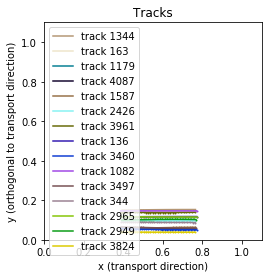

In [4]:
csv_data_set.plot_random_tracks(n=15)

In [5]:
dataset_train, dataset_test = csv_data_set.get_tf_data_sets_seq2seq_data(normalized=True)

In [6]:
path_to_model = '/home/daniel/Documents/19_20_WS/Praktikum_Anthro/Code/next_step_rnn/models/kendall2.h5'

rnn_model = tf.keras.models.load_model(path_to_model)

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_layer (Masking)      (64, 49, 2)               0         
_________________________________________________________________
rnn-0 (LSTM)                 (64, 49, 64)              17152     
_________________________________________________________________
rnn-1 (LSTM)                 (64, 49, 32)              12416     
_________________________________________________________________
dense (Dense)                (64, 49, 4)               132       
Total params: 29,700
Trainable params: 29,700
Non-trainable params: 0
_________________________________________________________________


# Statistiken auf Testdaten sammeln

Dieser Code entspricht dem Vorgehen in der Funktion _get_evaluation_data(...) in model.py

In [7]:
# _get_evaluation_data
data = {}
data['prediction'] = []
data['target'] = []
data['prediction_variance'] = []
data['squared_mahalanobis'] = []

for (batch_n, (inp_batch, target_batch)) in enumerate(dataset_test):
    inp_batch = inp_batch.numpy()
    target_batch = target_batch.numpy()

    # Kendall model
    _ = rnn_model.reset_states()
    predictions = rnn_model(inp_batch)

    pos_predictions = predictions[:, :, :2].numpy()
    var_predictions = tf.keras.backend.exp(predictions[:, :, 2:]).numpy()
   
    # store data
    for track_idx in range(inp_batch.shape[0]):
        seq_length = csv_data_set.get_last_timestep_of_track(inp_batch[track_idx])

        for time_step_i in range(seq_length):
            data['prediction'] += [pos_predictions[track_idx, time_step_i, :]]
            data['prediction_variance'] += [var_predictions[track_idx, time_step_i, :]]
            data['target'] += [target_batch[track_idx, time_step_i, :]]
            data['squared_mahalanobis'] += [np.sum(
                ((data['target'][-1] - data['prediction'][-1]) ** 2) / data['prediction_variance'][
                    -1])]
            
data['prediction'] = np.array(data['prediction'])
data['target'] = np.array(data['target'])
data['prediction_variance'] = np.array(data['prediction_variance'])
data['squared_mahalanobis'] = np.array(data['squared_mahalanobis'])


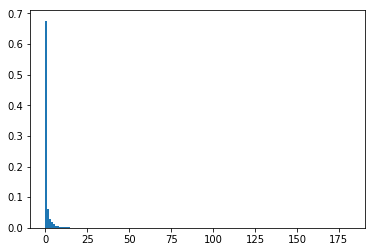

In [8]:
plt.hist(data['squared_mahalanobis'], bins=150, density=True, stacked=True);

# Kalibrierung

entspricht dem Vorgehen im Code, außer dass hier nun chi2 und squared_mahalanobis verwendet wird.

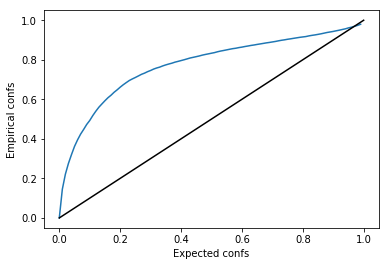

In [9]:
expected_confs = np.arange(0, 1, 0.01)
empirical_confs = []
counter = []

N = data['squared_mahalanobis'].shape[0]

for expected_confidence in expected_confs:
    # critical value
    expected_critical_value = chi2.ppf(expected_confidence, df=2)
    # which mahal distance is <= than critical value
    count_falls_into = np.count_nonzero(data['squared_mahalanobis'] <= expected_critical_value)
    counter.append(count_falls_into)
    empirical_confs.append(count_falls_into / N)

empirical_confs = np.array(empirical_confs)

plt.plot(expected_confs, empirical_confs);
plt.xlabel('Expected confs');
plt.ylabel('Empirical confs');

plt.plot((0,1), (0,1), color="black");

In [10]:
ir = IsotonicRegression()
y_ = ir.fit_transform(empirical_confs, expected_confs)

# Konkrete Konfidenz kalibrieren

In [11]:
query_conf = 0.67
corrected_conf = ir.predict([query_conf])[0]
print("query_conf=",query_conf, " corrected_conf=", corrected_conf)

critical_value_old = chi2.ppf(query_conf, df=2)
critical_value_new = chi2.ppf(corrected_conf, df=2)

print("critical_value_old", critical_value_old)
print("critical_value_new", critical_value_new)

print('... Circa {}% der quadrierten Mahal. Distanzen soll kleiner sein als'.format(query_conf*100), critical_value_new)


query_conf= 0.67  corrected_conf= 0.2071039473684211
critical_value_old 2.217325249043222
critical_value_new 0.4641262942198945
... Circa 67.0% der quadrierten Mahal. Distanzen soll kleiner sein als 0.4641262942198945


In [12]:
# Probe
ratio = np.count_nonzero(data['squared_mahalanobis'] <= critical_value_new) / N
print("... tatsächlich sind es {}%.".format(ratio*100))


... tatsächlich sind es 67.03243504921737%.


## Wie kommt man von der alten Ellipse zur neuen?

Die kalibrierte Ellipse "enthält" die kalibrierten Varianzen:

$$ \frac{x^2}{\sigma_x^2}  + \frac{y^2}{\sigma_y^2}  = \text{critical_value_new} $$

critical_value_new ist der kritische Wert der chi2-Verteilung.

Die unkalibrierte Ellipse ist durch einen multiplikativen Faktor verzerrt:

$$ \frac{x^2}{\sigma_x^2}  * r  + \frac{y^2}{\sigma_y^2}  * r   = \text{critical_value_old} $$

$$ r * \text{critical_value_new} = \text{critical_value_old} $$

$$ r  = \frac{\text{critical_value_old}}{\text{critical_value_new}}$$

Damit kommt man jetzt auf die neuen Sigmas:

$$ \frac{ \sigma_x^2}{ r } = \sigma_\text{neu, x}^2$$


In [13]:
# Plotten
# Rastergröße ra
ra = 0.005
# 2d equation space
x = np.linspace(-ra, ra, 1000)
y = np.linspace(-ra, ra, 1000)
X, Y = np.meshgrid(x,y)

In [14]:
# Im Beispiel
r = critical_value_old / critical_value_new
print(r)

4.777417863752175


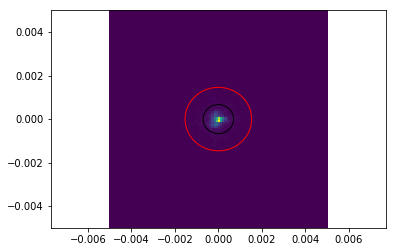

In [19]:
plt.hist2d((data['prediction'][:, 0]-data['target'][:, 0]), 
           (data['prediction'][:, 1]-data['target'][:, 1]), 
           bins=100, 
           range=[[-ra,ra], [-ra, ra]]
          );
plt.axis('equal');

var_x = data['prediction_variance'][1, 0]
var_y = data['prediction_variance'][1, 1]

# alte ellipse
F = np.sqrt((X**2)/var_x + (Y**2)/var_y) - critical_value_old
plt.contour(X,Y,F,[0], colors="red", linewidths=1);

# transformierte ellipse
F = np.sqrt(((X**2)/(var_x/r)) + ((Y**2)/(var_y/r))) - critical_value_old
plt.contour(X,Y,F,[0], colors="black", linewidths=1);

In rot: alte Ellipse (Unsicherheiten werden überschätzt)

In schwarz: Korrigierte Ellipse ist kleiner

/home/daniel/Documents/19_20_WS/Praktikum_Anthro/Code/next_step_rnn/cpu_env/lib/python3.5/site-packages/matplotlib/contour.py:1243: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


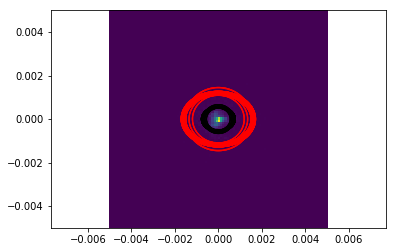

In [16]:
for prediction_i in range(100):

    plt.hist2d((data['prediction'][:, 0]-data['target'][:, 0]), 
               (data['prediction'][:, 1]-data['target'][:, 1]), 
               bins=100, 
               range=[[-ra,ra], [-ra, ra]]
              );
    plt.axis('equal');

    var_x = data['prediction_variance'][prediction_i, 0]
    var_y = data['prediction_variance'][prediction_i, 1]

    # alte ellipse
    F = np.sqrt((X**2)/var_x + (Y**2)/var_y) - critical_value_old
    plt.contour(X,Y,F,[0], colors="red", linewidths=1);

    # transformierte ellipse
    F = np.sqrt(((X**2)/(var_x/r)) + ((Y**2)/(var_y/r))) - critical_value_old
    plt.contour(X,Y,F,[0], colors="black", linewidths=1);